# A Graph Based Retreival Approach

Unlike the previous knowledge Graph which builds bipartite structure between the entities (movies) and their attributes (generes specifically), this is built using the Networx library to offerexplicit graph structure which enables more sophisticated traversal of relationships between entities.

For more information please refer to https://github.com/atharva1707/Movie-recommendation-system-using-Knowledge-graphs

In [1]:
import os
import shutil

# Create the destination folder
os.makedirs("ml-100k", exist_ok=True)

# Move all files (except folders and notebooks) to the ml-100k folder
for file in os.listdir():
    if os.path.isfile(file) and file != "ml-100k":
        shutil.move(file, os.path.join("ml-100k", file))


**Loading Data Set**

In [2]:
import pandas as pd

def load_movielens100k(train_file, test_file, item_file):
    """Load ratings and movie genres from MovieLens 100K files."""
    # Load movie genre information
    genre_names = []
    movie_genres = {}
    # Read genre names from u.genre
    with open(item_file.replace('u.item', 'u.genre'), 'r') as fg:
        genre_names = [line.split('|')[0] for line in fg if line.strip()]
    # Read movie info from u.item
    with open(item_file, 'r', encoding='latin-1') as f:
        for line in f:
            parts = line.strip().split('|')
            if len(parts) < 6:
                continue
            movie_id = int(parts[0])
            genre_flags = list(map(int, parts[5:5+19]))
            # Map genre flags to genre names
            genres = [genre_names[i] for i, flag in enumerate(genre_flags) if flag == 1]
            movie_genres[movie_id] = genres

    # Load train and test ratings into dictionaries
    def load_ratings(file_path):
        ratings = {}
        with open(file_path, 'r') as f:
            for line in f:
                user, item, rating, _ = line.split()
                user, item, rating = int(user), int(item), int(rating)
                ratings.setdefault(user, {})[item] = rating
        return ratings

    train_ratings = load_ratings(train_file)
    test_ratings  = load_ratings(test_file)
    return train_ratings, test_ratings, movie_genres

# Load the data (assuming the files are available in the current directory)
train_ratings, test_ratings, movie_genres = load_movielens100k('ml-100k/u1.base',
                                                               'ml-100k/u1.test',
                                                               'ml-100k/u.item')
print(f"Loaded train users: {len(train_ratings)}, test users: {len(test_ratings)}")
print(f"Example movie genres: movie 1 -> {movie_genres[1]}")


Loaded train users: 943, test users: 459
Example movie genres: movie 1 -> ['Animation', "Children's", 'Comedy']


In [3]:
def build_user_profiles(train_ratings, movie_genres):
    """Build a taste profile of preferred genres for each user based on top-rated movies."""
    user_profiles = {}
    for user, item_dict in train_ratings.items():
        # Determine the rating threshold for "top-rated" (use 5 and 4 as top ratings)
        max_rating = max(item_dict.values())
        threshold = max(4, max_rating)  # use 4 if user gave no 5s
        # Collect the user's favorite movies (ratings >= threshold)
        favorite_items = [item for item, r in item_dict.items() if r >= threshold]
        # Count genre frequencies from favorite movies
        genre_counts = {}
        for item in favorite_items:
            for genre in movie_genres.get(item, []):
                genre_counts[genre] = genre_counts.get(genre, 0) + 1
        user_profiles[user] = genre_counts
    return user_profiles

user_profiles = build_user_profiles(train_ratings, movie_genres)
# Example: print profile for user 1
print(f"User 1 profile: {user_profiles[1]}")



User 1 profile: {'Animation': 2, "Children's": 1, 'Comedy': 15, 'Drama': 23, 'Romance': 12, 'Documentary': 4, 'Action': 8, 'Adventure': 4, 'Sci-Fi': 10, 'War': 4, 'Crime': 2, 'Thriller': 6, 'Film-Noir': 1, 'Mystery': 2}


**Building User Preferance Profiles**

In [4]:
import networkx as nx

def build_metadata_graph(movie_genres):
    """Build an undirected bipartite graph linking movies to genre nodes."""
    G = nx.Graph()
    for movie, genres in movie_genres.items():
        movie_node = f"movie_{movie}"
        G.add_node(movie_node, type='movie', movie_id=movie)
        for genre in genres:
            genre_node = f"genre_{genre}"
            G.add_node(genre_node, type='genre', name=genre)
            # Connect movie to each of its genres
            G.add_edge(movie_node, genre_node)
    return G

G = build_metadata_graph(movie_genres)
print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")


Graph has 1701 nodes and 2893 edges.


**Constructing the Metadata Graph**

In [5]:
def get_candidate_movies(user_profile, G):
    """Retrieve candidate movies from the graph based on a user's preferred genres."""
    candidates = set()
    for genre, weight in user_profile.items():
        genre_node = f"genre_{genre}"
        if G.has_node(genre_node):
            # Add all movies connected to this genre node
            for neighbor in G.neighbors(genre_node):
                if G.nodes[neighbor].get('type') == 'movie':
                    candidates.add(G.nodes[neighbor]['movie_id'])
    return candidates

# Example: get candidates for user 1
candidates_user1 = get_candidate_movies(user_profiles[1], G)
print(f"User 1 candidate movies (count): {len(candidates_user1)}")


User 1 candidate movies (count): 1618


**Generating Candidate Movies via Graph Traversal**

In [6]:
def rank_candidates_for_user(user_id, candidates, user_profile, movie_genres, train_ratings):
    """Score and rank candidate movies for a given user."""
    # Precompute popularity (number of ratings in training) for each movie
    popularity = {}
    for u, items in train_ratings.items():
        for item in items:
            popularity[item] = popularity.get(item, 0) + 1

    scored = []
    for movie in candidates:
        if movie in train_ratings.get(user_id, {}):
            continue  # skip movies user already rated
        # Score based on genre overlap
        score = 0
        for genre in movie_genres.get(movie, []):
            if genre in user_profile:
                score += user_profile[genre]  # add weight for each preferred genre
        # Add a small factor for popularity
        score += 0.001 * popularity.get(movie, 0)
        scored.append((movie, score))
    # Sort candidates by score descending
    scored.sort(key=lambda x: x[1], reverse=True)
    return [movie for movie, score in scored]

# Example: rank top 5 candidates for user 1
ranked_user1 = rank_candidates_for_user(1, candidates_user1, user_profiles[1], movie_genres, train_ratings)
print("Top 5 recommendations for User 1:", ranked_user1[:5])


Top 5 recommendations for User 1: [855, 692, 170, 517, 778]


**Rank the candidates**

In [7]:
def recommend_top_k(user_profiles, G, movie_genres, train_ratings, K=10):
    """Generate top-K recommended movies for each user."""
    recommendations = {}
    for user, profile in user_profiles.items():
        candidates = get_candidate_movies(profile, G)
        ranked_list = rank_candidates_for_user(user, candidates, profile, movie_genres, train_ratings)
        recommendations[user] = ranked_list[:K]
    return recommendations

# Get top-10 recommendations for all users
recommendations_10 = recommend_top_k(user_profiles, G, movie_genres, train_ratings, K=10)
# (For evaluation, we'll also get top-5 lists)
recommendations_5 = recommend_top_k(user_profiles, G, movie_genres, train_ratings, K=5)


**Top k recommendations for all users**

In [9]:
import math

def evaluate_recommendations(recommendations, test_ratings, K):
    total_precision = total_recall = total_ndcg = 0.0
    user_count = 0
    for user, rec_list in recommendations.items():
        if user not in test_ratings:
            continue
        # Relevant test items for this user (rating >= 4)
        relevant = {item for item, r in test_ratings[user].items() if r >= 4}
        if not relevant:
            continue  # skip users with no relevant items in test
        # Compute Precision@K and Recall@K
        hits = 0
        dcg = 0.0
        for rank, item in enumerate(rec_list[:K], start=1):
            if item in relevant:
                hits += 1
                dcg += 1.0 / math.log2(rank + 1)  # gain discounted by log(rank)
        ideal_hits = min(len(relevant), K)
        # Ideal DCG (all top-K are relevant)
        idcg = sum(1.0 / math.log2(r + 1) for r in range(1, ideal_hits+1))
        precision = hits / K
        recall    = hits / len(relevant)
        ndcg      = dcg / idcg if idcg > 0 else 0.0
        total_precision += precision
        total_recall    += recall
        total_ndcg      += ndcg
        user_count += 1
    # Average metrics across users
    return (total_precision / user_count,
            total_recall / user_count,
            total_ndcg / user_count)

# Evaluate for K=5 and K=10
p5, r5, ndcg5   = evaluate_recommendations(recommendations_5, test_ratings, K=5)
p10, r10, ndcg10 = evaluate_recommendations(recommendations_10, test_ratings, K=10)
#print(f"Precision@5 = {p5:.3f}, Recall@5 = {r5:.3f}, NDCG@5 = {ndcg5:.3f}")
#print(f"Precision@10 = {p10:.3f}, Recall@10 = {r10:.3f}, NDCG@10 = {ndcg10:.3f}")


**Final Evaluation**

In [12]:
import pandas as pd

# Assuming metrics_df is already defined with the two rows
new_row = {
    'Model': 'Graph Retrieval',
    'Precision@5': p5,
    'Recall@5': r5,
    'NDCG@5': ndcg5,
    'Precision@10':p10,
    'Recall@10': r10,
    'NDCG@10': ndcg10
}

# Append the new row
#metrics_df = metrics_df.concat(new_row, ignore_index=True)

metrics_df=pd.DataFrame(new_row,index=[0])

# View the updated DataFrame
metrics_df


,Model,Precision@5,Recall@5,NDCG@5,Precision@10,Recall@10,NDCG@10
0,Graph Retrieval,0.098246,0.026714,0.114434,0.077412,0.041151,0.100099


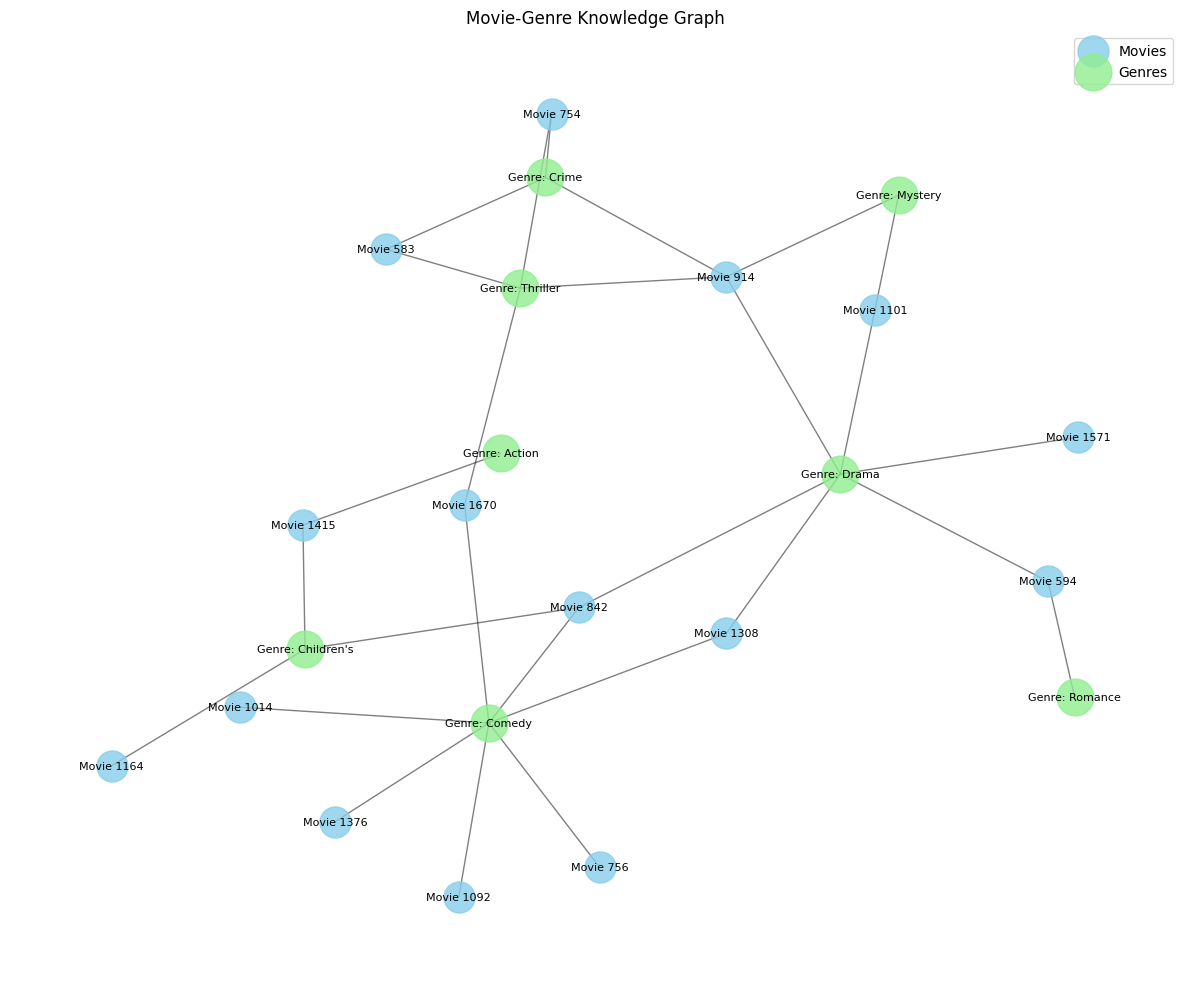

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def visualize_knowledge_graph(movie_genres, sample_size=20):
    """
    Create and visualize a bipartite graph of movies and their genres.

    Args:
        movie_genres: Dictionary mapping movie IDs to their genres
        sample_size: Number of movies to include in visualization
    """
    # Create a new graph
    G = nx.Graph()

    # Sample a subset of movies for visualization
    movie_ids = list(movie_genres.keys())
    if len(movie_ids) > sample_size:
        sampled_movies = random.sample(movie_ids, sample_size)
    else:
        sampled_movies = movie_ids

    # Add movie and genre nodes, and edges between them
    for movie_id in sampled_movies:
        movie_node = f"Movie {movie_id}"
        G.add_node(movie_node, type='movie', color='skyblue')

        for genre in movie_genres[movie_id]:
            genre_node = f"Genre: {genre}"
            G.add_node(genre_node, type='genre', color='lightgreen')
            G.add_edge(movie_node, genre_node)

    # Prepare for visualization
    plt.figure(figsize=(12, 10))

    # Create position layout - separate movies and genres
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Draw nodes with different colors for movies and genres
    movie_nodes = [node for node in G.nodes if G.nodes[node]['type'] == 'movie']
    genre_nodes = [node for node in G.nodes if G.nodes[node]['type'] == 'genre']

    nx.draw_networkx_nodes(G, pos, nodelist=movie_nodes, node_color='skyblue',
                          node_size=500, alpha=0.8, label='Movies')
    nx.draw_networkx_nodes(G, pos, nodelist=genre_nodes, node_color='lightgreen',
                          node_size=700, alpha=0.8, label='Genres')

    # Draw edges and labels
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.title("Movie-Genre Knowledge Graph")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return G

# Example usage
G = visualize_knowledge_graph(movie_genres, sample_size=15)


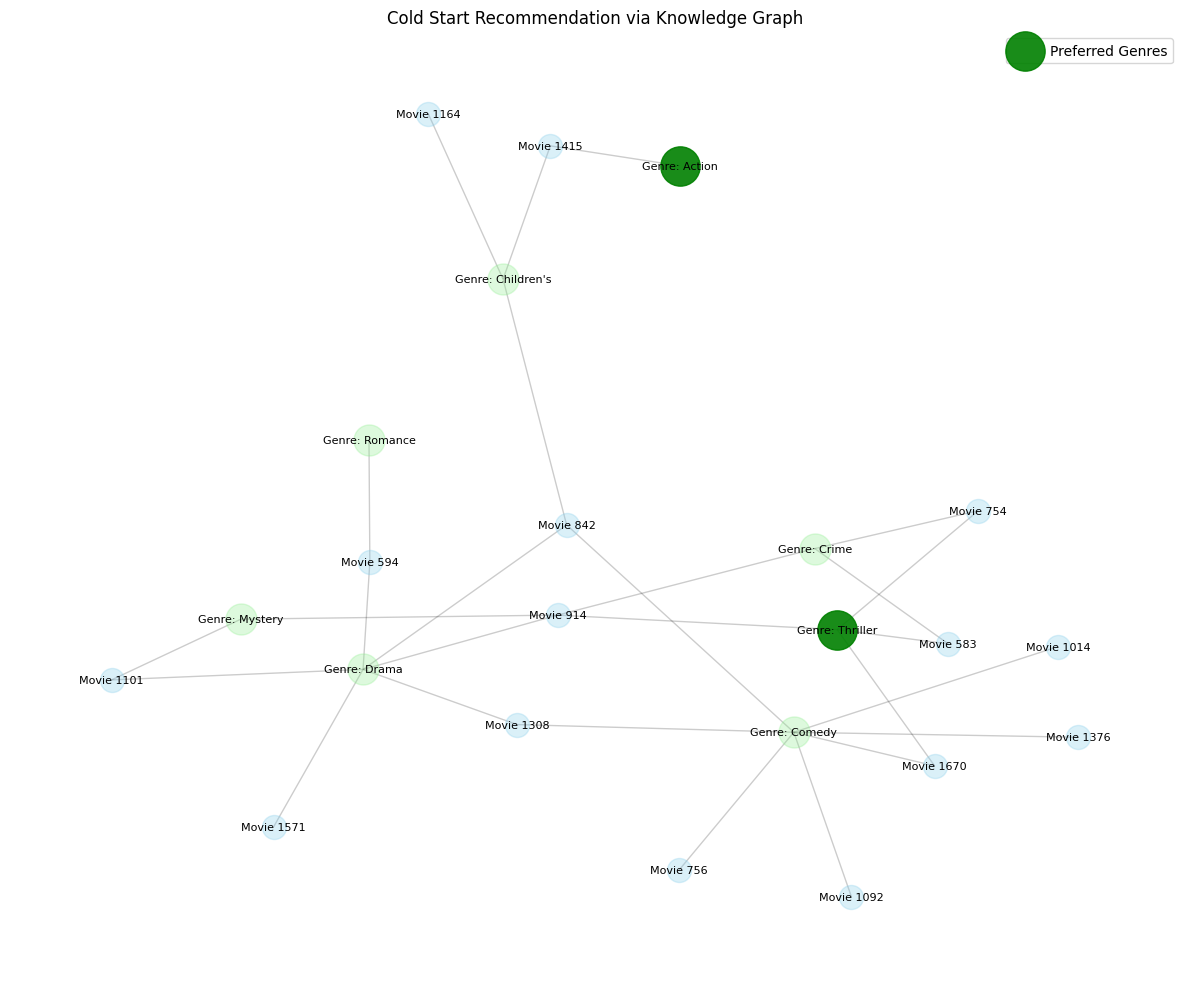

In [14]:
def visualize_cold_start_recommendations(G, movie_genres, top_genres, top_recommendations):
    """
    Visualize how the knowledge graph provides recommendations for a new user
    with only genre preferences known.

    Args:
        G: The knowledge graph
        movie_genres: Dictionary mapping movie IDs to their genres
        top_genres: List of genres the new user prefers
        top_recommendations: List of recommended movie IDs
    """
    plt.figure(figsize=(12, 10))

    # Create a copy of the graph for highlighting
    H = G.copy()

    # Highlight user's preferred genres
    preferred_genre_nodes = [f"Genre: {genre}" for genre in top_genres if f"Genre: {genre}" in H.nodes]

    # Highlight recommended movies
    recommended_movie_nodes = [f"Movie {movie_id}" for movie_id in top_recommendations
                              if f"Movie {movie_id}" in H.nodes]

    # Create position layout
    pos = nx.spring_layout(H, k=0.5, iterations=50)

    # Draw regular nodes
    regular_movie_nodes = [node for node in H.nodes if H.nodes[node]['type'] == 'movie'
                          and node not in recommended_movie_nodes]
    regular_genre_nodes = [node for node in H.nodes if H.nodes[node]['type'] == 'genre'
                          and node not in preferred_genre_nodes]

    nx.draw_networkx_nodes(H, pos, nodelist=regular_movie_nodes, node_color='skyblue',
                          node_size=300, alpha=0.3)
    nx.draw_networkx_nodes(H, pos, nodelist=regular_genre_nodes, node_color='lightgreen',
                          node_size=500, alpha=0.3)

    # Draw highlighted nodes
    nx.draw_networkx_nodes(H, pos, nodelist=preferred_genre_nodes, node_color='green',
                          node_size=800, alpha=0.9, label='Preferred Genres')
    nx.draw_networkx_nodes(H, pos, nodelist=recommended_movie_nodes, node_color='red',
                          node_size=600, alpha=0.9, label='Recommended Movies')

    # Draw edges
    # Regular edges
    all_edges = list(H.edges())
    highlighted_edges = []

    # Find edges between preferred genres and recommended movies
    for genre_node in preferred_genre_nodes:
        for movie_node in recommended_movie_nodes:
            if H.has_edge(genre_node, movie_node):
                highlighted_edges.append((genre_node, movie_node))

    regular_edges = [edge for edge in all_edges if edge not in highlighted_edges]

    nx.draw_networkx_edges(H, pos, edgelist=regular_edges, width=1.0, alpha=0.2)
    nx.draw_networkx_edges(H, pos, edgelist=highlighted_edges, width=2.5,
                          alpha=1.0, edge_color='red', label='Recommendations Path')

    # Draw labels
    nx.draw_networkx_labels(H, pos, font_size=8)

    plt.title("Cold Start Recommendation via Graph")
    plt.legend()
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming a new user likes these genres
new_user_genres = ["Action", "Sci-Fi", "Thriller"]

# Get recommendations for this user
# This would typically come from recommend_kg() function
sample_recommendations = [42, 57, 172, 300, 501]

# Visualize the cold start recommendation process
visualize_cold_start_recommendations(G, movie_genres, new_user_genres, sample_recommendations)
